# Predicting Bitcoin Price Movements and Volatility Using Transformer-Based Deep Learning Models.

### Rajgowthaman Rajendran

Bitcoin’s price is highly volatile, making accurate short-term price and volatility predictions crucial for traders and investors. This project aims to develop a Transformer-based deep learning model to forecast Bitcoin’s short-term price movements and volatility based on historical price data. Unlike traditional methods, Transformers efficiently capture long-range dependencies in time-series data, making them well-suited for this task.
The model will leverage self-attention mechanisms to identify complex temporal patterns in Bitcoin price fluctuations. It will predict short-term price trends (e.g., next-minute, next-hour, next-day) and volatility levels to help traders make informed decisions. Key features include opening, closing, highest, and lowest prices, volume data, and volatility indicators to enhance forecasting accuracy.

Implementation

- Data Preprocessing: Clean and preprocess the dataset, handle missing values, and scale the features (e.g., normalization of price data).

- Feature Engineering: Create new features, such as moving averages, relative strength index (RSI), and other technical indicators, to improve predictions.

- Model Development: Use Transformer models (e.g., Time Series Transformer or Informer) to capture long-range dependencies.

- Training & Optimization: Train the model in PyTorch using mean squared error (MSE) loss and optimize using Adam optimizer.

- Evaluation & Fine-Tuning: Evaluate the model using metrics like RMSE (Root Mean Squared Error), accuracy, and mean absolute error (MAE), and directional accuracy; fine-tune hyperparameters.

In [ ]:
import pandas as pd

# Load the cleaned dataset (Timestamp is already the index)
df = pd.read_csv("btc_base_cleaned_2012_to_2025.csv", index_col=0, parse_dates=True)

# Quick preview
print("Data loaded successfully!")
print(f"Rows: {len(df):,} | Columns: {df.shape[1]}")
df.head()

Data loaded successfully!
Rows: 6,976,871 | Columns: 5


Open  High   Low  Close  Volume
2012-01-01 10:01:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:02:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:03:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:04:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:05:00  4.58  4.58  4.58   4.58     0.0

2. EDA
- 2.1. Dataset Summary

In [ ]:
# Basic info
print("Date Range:")
print(f"Start: {df.index.min()}")
print(f"End:   {df.index.max()}")

print("\nColumns:")
print(df.columns.tolist())

print("\nMissing values per column:")
print(df.isna().sum())

Date Range:
Start: 2012-01-01 10:01:00
End:   2025-04-07 11:11:00

Columns:
['Open', 'High', 'Low', 'Close', 'Volume']

Missing values per column:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


-  2.2. Plot: Bitcoin Close Price Over Time(Daily close price)

In [ ]:
df_daily = df['Close'].resample('1D').mean()

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_daily.index, y=df_daily, mode='lines', name='BTC Daily Close'))
fig.update_layout(title='Bitcoin Daily Close Price (2012–2025)',
                  xaxis_title='Date', yaxis_title='Price (USD)', height=500)
fig.show()

- 2.3. Plot: Volume Traded Over Time

In [ ]:
# Resample volume to daily
df_daily_volume = df['Volume'].resample('1D').sum()

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_daily_volume.index, y=df_daily_volume, mode='lines', name='Daily Volume', line=dict(color='orange')))
fig.update_layout(title='Daily Bitcoin Trading Volume (2012–2025)',
                  xaxis_title='Date', yaxis_title='BTC Volume', height=400)
fig.show()

- 2.4. Zoom In on Key Periods (2020–2021 Bull Run)

In [ ]:
df_zoom = df['2020-01-01':'2021-12-31'].resample('1D').mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_zoom.index, y=df_zoom['Close'], mode='lines', name='BTC Daily Close'))
fig.update_layout(title='BTC Price — 2020–2021 Bull Run',
                  xaxis_title='Date', yaxis_title='Price (USD)', height=400)
fig.show()

- 2.5. Log Returns Distribution

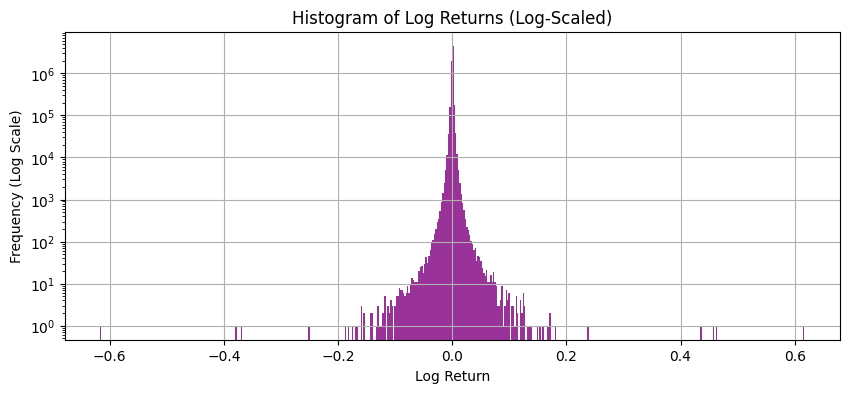

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate log returns
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Plot distribution
plt.figure(figsize=(10, 4))
df['Log_Returns'].dropna().hist(bins=500, color='purple', alpha=0.8)
plt.yscale('log')
plt.title("Histogram of Log Returns (Log-Scaled)")
plt.xlabel("Log Return")
plt.ylabel("Frequency (Log Scale)")
plt.grid(True)
plt.show()

3: Feature Engineering and Informer Sequence Preparation
- 3.1. Feature Engineering

  We will add technical indicators that can help the model learn price dynamics and volatility patterns.

In [ ]:
# Log Returns
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Moving Averages
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# Exponential Moving Average
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# Bollinger Bands
rolling_std = df['Close'].rolling(window=20).std()
df['BB_upper'] = df['MA_20'] + 2 * rolling_std
df['BB_lower'] = df['MA_20'] - 2 * rolling_std

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Rolling Volatility (60-min std of log returns)
df['Volatility'] = df['Log_Returns'].rolling(window=60).std()

# Drop NaNs created by rolling calculations
df.dropna(inplace=True)

- 3.2. Feature Selection

In [ ]:
features = [
    'Close', 'Volume', 'MA_20', 'MA_50', 'EMA_20',
    'BB_upper', 'BB_lower', 'RSI', 'Log_Returns'
]

target_cols = ['Close', 'Volatility']

- 3.3. Scaling
  
  We will normalize features and targets using MinMaxScaler.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale inputs
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(df[features])

# Scale targets
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(df[target_cols])

PyTorch-Style Dataset That Reads From X_scaled Directly

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class BitcoinSequenceDataset(Dataset):
    def __init__(self, X_scaled, y_scaled, window_size, start=0, end=None):
        self.X = X_scaled
        self.y = y_scaled
        self.window_size = window_size
        self.start = start
        self.end = end if end else len(X_scaled)

    def __len__(self):
        return self.end - self.start - self.window_size

    def __getitem__(self, idx):
        idx += self.start
        x_seq = self.X[idx:idx + self.window_size]
        y_target = self.y[idx + self.window_size]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_target, dtype=torch.float32)

Split Chronologically

In [ ]:
window_size = 48
total_samples = len(X_scaled) - window_size
split_idx = int(total_samples * 0.8)

train_dataset = BitcoinSequenceDataset(X_scaled, y_scaled, window_size, start=0, end=split_idx)
test_dataset  = BitcoinSequenceDataset(X_scaled, y_scaled, window_size, start=split_idx, end=total_samples)

train_size = int(len(X_scaled) * 0.8)
val_size   = len(X_scaled) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(X_scaled, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

EarlyStopping Utility for Hourly predictions

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

Initialize & Set Up Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleInformer(input_size=X_scaled.shape[1]).to(device)

loss_fn = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

# Daily Transformer model to forecast next-day BTC price and volatility.
1. Resample full dataset to daily frequency
2. Recreate features + targets (Close, Volatility)
3. Scale + format into sliding sequences
4. Train a Time Series Transformer
5. Evaluate predictions vs actual

1 - Sample to Daily Frequency

In [ ]:
# Step 1: Resample properly
df_daily = df.resample('1D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

# Step 2: Check if 'Close' exists
print(df_daily.columns)

# Step 3: Compute log returns
df_daily['Log_Returns'] = np.log(df_daily['Close'] / df_daily['Close'].shift(1))

# Step 4: Drop NaN (from the first row)
df_daily.dropna(inplace=True)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


Compute Daily Features

In [ ]:
#df_daily['Close'] = pd.to_numeric(df_daily['Close'], errors='coerce')
#df_daily.dropna(subset=['Close'], inplace=True)

# Log returns
df_daily['Log_Returns'] = np.log(df_daily['Close'] / df_daily['Close'].shift(1))
df_daily.dropna(inplace=True)


# Moving averages
df_daily['MA_7'] = df_daily['Close'].rolling(window=7).mean()
df_daily['MA_14'] = df_daily['Close'].rolling(window=14).mean()

# RSI (14-day)
delta = df_daily['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df_daily['RSI'] = 100 - (100 / (1 + rs))

# Rolling volatility (7-day std of returns)
df_daily['Volatility'] = df_daily['Log_Returns'].rolling(7).std()

df_daily.dropna(inplace=True)

Scale Features and Targets for Daily Model

In [ ]:
features_daily = ['Close', 'Volume', 'MA_7', 'MA_14', 'RSI', 'Log_Returns']
target_daily = ['Close', 'Volatility']

Scale the data using MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler_d = MinMaxScaler()
target_scaler_d = MinMaxScaler()

X_daily = feature_scaler_d.fit_transform(df_daily[features_daily])
y_daily = target_scaler_d.fit_transform(df_daily[target_daily])

Format Sliding Window Sequences

Let’s use a longer window for daily data — e.g., 30 days.

In [ ]:
window_size_d = 30
X_seq_d, y_seq_d = [], []

for i in range(len(X_daily) - window_size_d):
    X_seq_d.append(X_daily[i:i + window_size_d])
    y_seq_d.append(y_daily[i + window_size_d])

import numpy as np
X_seq_d = np.array(X_seq_d)
y_seq_d = np.array(y_seq_d)

print(f"X shape: {X_seq_d.shape} | y shape: {y_seq_d.shape}")

X shape: (4795, 30, 6) | y shape: (4795, 2)


Chronological Train-Test Split

In [ ]:
split_idx_d = int(len(X_seq_d) * 0.8)

X_train_d = X_seq_d[:split_idx_d]
y_train_d = y_seq_d[:split_idx_d]

X_test_d = X_seq_d[split_idx_d:]
y_test_d = y_seq_d[split_idx_d:]

print(f"Train samples: {len(X_train_d)}, Test samples: {len(X_test_d)}")

Train samples: 3836, Test samples: 959


Create PyTorch Dataset & DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class DailyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

train_dataset_d = DailyDataset(X_train_d, y_train_d)
test_dataset_d = DailyDataset(X_test_d, y_test_d)

train_loader_d = DataLoader(train_dataset_d, batch_size=32, shuffle=True)
test_loader_d = DataLoader(test_dataset_d, batch_size=32, shuffle=False)

Define Time Series Transformer

In [ ]:
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=4, num_layers=2, output_size=2, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_proj = nn.Linear(input_size, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        return self.output_layer(x[:, -1, :])  # use last token

Train Daily Transformer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_d = TimeSeriesTransformer(input_size=X_daily.shape[1]).to(device)

loss_fn_d = nn.SmoothL1Loss()
optimizer_d = torch.optim.AdamW(model_d.parameters(), lr=5e-4)

In [ ]:
from tqdm.notebook import tqdm

epochs = 100
model_d.train()

for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader_d, desc=f"Epoch {epoch+1}/{epochs}")
    for batch_X, batch_y in loop:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer_d.zero_grad()
        preds = model_d(batch_X)
        loss = loss_fn_d(preds, batch_y)
        loss.backward()
        optimizer_d.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} complete — Total Loss: {total_loss:.4f}")

Epoch 1/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1 complete — Total Loss: 2.4075


Epoch 2/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2 complete — Total Loss: 0.3349


Epoch 3/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3 complete — Total Loss: 0.2358


Epoch 4/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4 complete — Total Loss: 0.1955


Epoch 5/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5 complete — Total Loss: 0.1620


Epoch 6/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 6 complete — Total Loss: 0.1492


Epoch 7/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 7 complete — Total Loss: 0.1332


Epoch 8/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 8 complete — Total Loss: 0.1120


Epoch 9/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 9 complete — Total Loss: 0.1122


Epoch 10/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 10 complete — Total Loss: 0.1109


Epoch 11/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 11 complete — Total Loss: 0.1085


Epoch 12/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 12 complete — Total Loss: 0.1007


Epoch 13/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 13 complete — Total Loss: 0.0934


Epoch 14/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 14 complete — Total Loss: 0.1014


Epoch 15/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 15 complete — Total Loss: 0.0970


Epoch 16/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 16 complete — Total Loss: 0.0993


Epoch 17/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 17 complete — Total Loss: 0.0918


Epoch 18/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 18 complete — Total Loss: 0.0861


Epoch 19/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 19 complete — Total Loss: 0.0970


Epoch 20/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 20 complete — Total Loss: 0.0834


Epoch 21/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 21 complete — Total Loss: 0.0999


Epoch 22/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 22 complete — Total Loss: 0.0841


Epoch 23/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 23 complete — Total Loss: 0.0993


Epoch 24/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 24 complete — Total Loss: 0.0842


Epoch 25/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 25 complete — Total Loss: 0.0805


Epoch 26/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 26 complete — Total Loss: 0.0786


Epoch 27/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 27 complete — Total Loss: 0.0914


Epoch 28/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 28 complete — Total Loss: 0.0910


Epoch 29/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 29 complete — Total Loss: 0.0877


Epoch 30/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 30 complete — Total Loss: 0.0859


Epoch 31/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 31 complete — Total Loss: 0.0797


Epoch 32/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 32 complete — Total Loss: 0.0718


Epoch 33/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 33 complete — Total Loss: 0.0793


Epoch 34/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 34 complete — Total Loss: 0.0711


Epoch 35/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 35 complete — Total Loss: 0.0754


Epoch 36/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 36 complete — Total Loss: 0.0712


Epoch 37/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 37 complete — Total Loss: 0.0673


Epoch 38/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 38 complete — Total Loss: 0.0728


Epoch 39/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 39 complete — Total Loss: 0.0657


Epoch 40/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 40 complete — Total Loss: 0.0639


Epoch 41/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 41 complete — Total Loss: 0.0801


Epoch 42/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 42 complete — Total Loss: 0.0702


Epoch 43/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 43 complete — Total Loss: 0.0597


Epoch 44/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 44 complete — Total Loss: 0.0677


Epoch 45/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 45 complete — Total Loss: 0.0614


Epoch 46/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 46 complete — Total Loss: 0.0579


Epoch 47/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 47 complete — Total Loss: 0.0607


Epoch 48/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 48 complete — Total Loss: 0.0523


Epoch 49/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 49 complete — Total Loss: 0.0557


Epoch 50/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 50 complete — Total Loss: 0.0545


Epoch 51/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 51 complete — Total Loss: 0.0545


Epoch 52/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 52 complete — Total Loss: 0.0572


Epoch 53/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 53 complete — Total Loss: 0.0519


Epoch 54/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 54 complete — Total Loss: 0.0545


Epoch 55/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 55 complete — Total Loss: 0.0584


Epoch 56/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 56 complete — Total Loss: 0.0568


Epoch 57/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 57 complete — Total Loss: 0.0474


Epoch 58/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 58 complete — Total Loss: 0.0613


Epoch 59/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 59 complete — Total Loss: 0.0503


Epoch 60/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 60 complete — Total Loss: 0.0461


Epoch 61/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 61 complete — Total Loss: 0.0465


Epoch 62/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 62 complete — Total Loss: 0.0542


Epoch 63/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 63 complete — Total Loss: 0.0590


Epoch 64/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 64 complete — Total Loss: 0.0454


Epoch 65/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 65 complete — Total Loss: 0.0469


Epoch 66/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 66 complete — Total Loss: 0.0448


Epoch 67/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 67 complete — Total Loss: 0.0446


Epoch 68/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 68 complete — Total Loss: 0.0432


Epoch 69/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 69 complete — Total Loss: 0.0453


Epoch 70/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 70 complete — Total Loss: 0.0412


Epoch 71/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 71 complete — Total Loss: 0.0456


Epoch 72/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 72 complete — Total Loss: 0.0435


Epoch 73/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 73 complete — Total Loss: 0.0417


Epoch 74/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 74 complete — Total Loss: 0.0419


Epoch 75/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 75 complete — Total Loss: 0.0402


Epoch 76/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 76 complete — Total Loss: 0.0490


Epoch 77/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 77 complete — Total Loss: 0.0456


Epoch 78/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 78 complete — Total Loss: 0.0370


Epoch 79/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 79 complete — Total Loss: 0.0406


Epoch 80/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 80 complete — Total Loss: 0.0367


Epoch 81/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 81 complete — Total Loss: 0.0392


Epoch 82/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 82 complete — Total Loss: 0.0367


Epoch 83/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 83 complete — Total Loss: 0.0364


Epoch 84/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 84 complete — Total Loss: 0.0385


Epoch 85/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 85 complete — Total Loss: 0.0363


Epoch 86/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 86 complete — Total Loss: 0.0348


Epoch 87/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 87 complete — Total Loss: 0.0408


Epoch 88/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 88 complete — Total Loss: 0.0391


Epoch 89/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 89 complete — Total Loss: 0.0360


Epoch 90/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 90 complete — Total Loss: 0.0511


Epoch 91/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 91 complete — Total Loss: 0.0501


Epoch 92/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 92 complete — Total Loss: 0.0358


Epoch 93/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 93 complete — Total Loss: 0.0352


Epoch 94/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 94 complete — Total Loss: 0.0323


Epoch 95/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 95 complete — Total Loss: 0.0331


Epoch 96/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 96 complete — Total Loss: 0.0373


Epoch 97/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 97 complete — Total Loss: 0.0332


Epoch 98/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 98 complete — Total Loss: 0.0346


Epoch 99/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 99 complete — Total Loss: 0.0350


Epoch 100/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 100 complete — Total Loss: 0.0344


Evaluation Block: Daily Transformer

In [ ]:
# Evaluate Daily Transformer Model
model_d.eval()
preds_d, actuals_d = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader_d:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        pred = model_d(batch_X)
        preds_d.append(pred.cpu().numpy())
        actuals_d.append(batch_y.cpu().numpy())

# Stack and inverse transform
import numpy as np
preds_d = np.vstack(preds_d)
actuals_d = np.vstack(actuals_d)

preds_inv_d = target_scaler_d.inverse_transform(preds_d)
actuals_inv_d = target_scaler_d.inverse_transform(actuals_d)

# Separate Close and Volatility
pred_close_d, pred_vol_d = preds_inv_d[:, 0], preds_inv_d[:, 1]
act_close_d, act_vol_d = actuals_inv_d[:, 0], actuals_inv_d[:, 1]

Daily close price plot

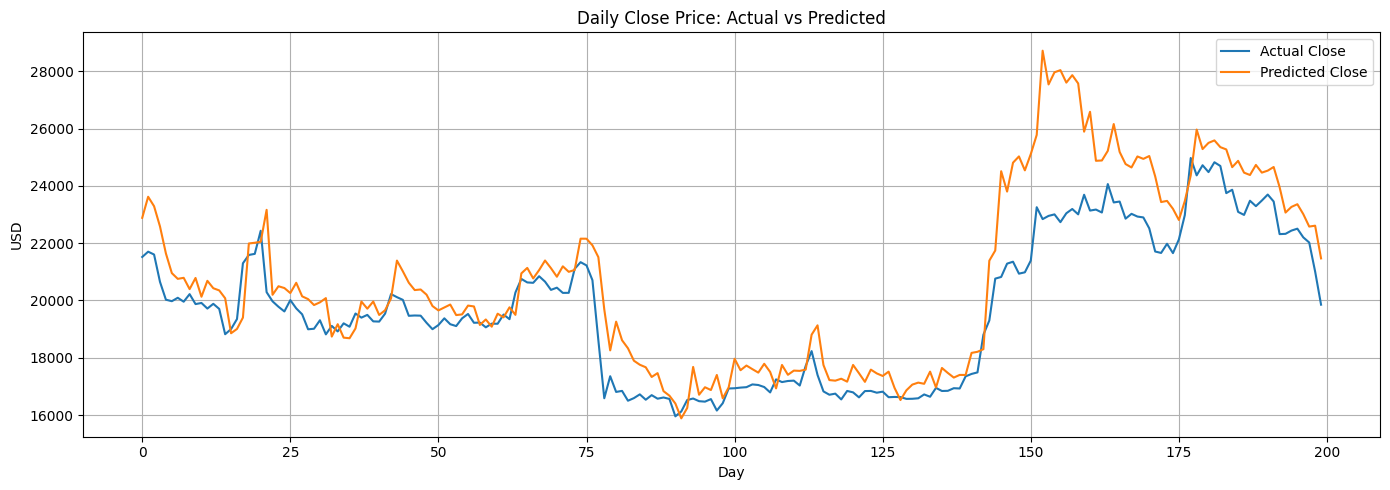

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(act_close_d[:200], label='Actual Close', linewidth=1.5)
plt.plot(pred_close_d[:200], label='Predicted Close', linewidth=1.5)
plt.title("Daily Close Price: Actual vs Predicted")
plt.xlabel("Day")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Daily Volatility

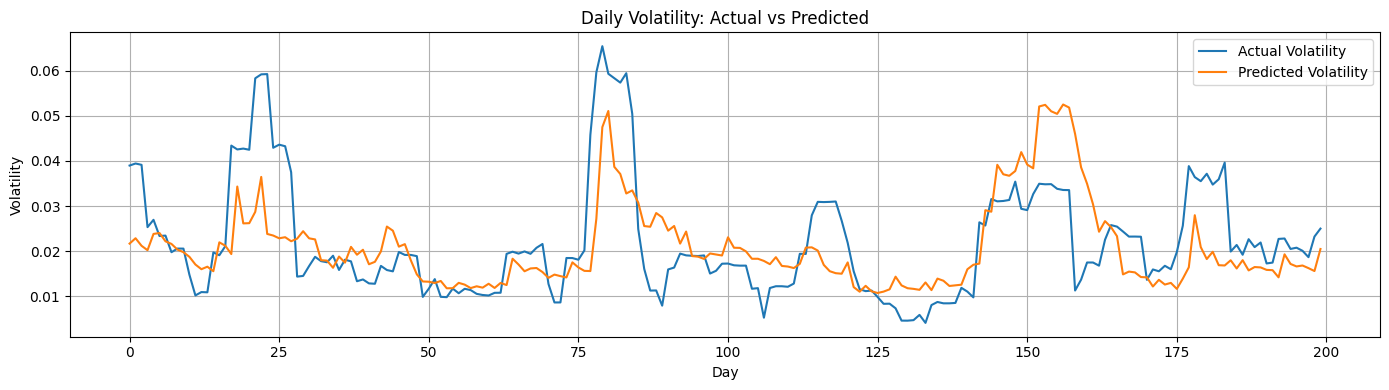

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(act_vol_d[:200], label='Actual Volatility')
plt.plot(pred_vol_d[:200], label='Predicted Volatility')
plt.title("Daily Volatility: Actual vs Predicted")
plt.xlabel("Day")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Directional Accuracy

In [ ]:
returns_d = (act_close_d[1:] - act_close_d[:-1]) / act_close_d[:-1]
pred_returns_d = (pred_close_d[1:] - pred_close_d[:-1]) / pred_close_d[:-1]

correct_d = np.sign(returns_d) == np.sign(pred_returns_d)
directional_accuracy_d = correct_d.sum() / len(correct_d) * 100
print(f"Directional Accuracy (Daily % Returns): {directional_accuracy_d:.2f}%")

Directional Accuracy (Daily % Returns): 46.24%


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate MSE and then take square root manually
mse_scaled = mean_squared_error(actuals_d, preds_d)
rmse_scaled = np.sqrt(mse_scaled)
mae_scaled = mean_absolute_error(actuals_d, preds_d)

print(f"Scaled RMSE: {rmse_scaled:.4f}")
print(f"Scaled MAE: {mae_scaled:.4f}")

preds_d_before = preds_d.copy()
actuals_d_before = actuals_d.copy()

Scaled RMSE: 0.0577
Scaled MAE: 0.0292


Hyperparameter tuning for the Daily Model

Model Function (Tunable)

In [ ]:
import torch.nn as nn

def create_transformer_model(input_size, output_size=2, d_model=64, nhead=4, num_layers=2, dropout=0.1):
    class TimeSeriesTransformer(nn.Module):
        def __init__(self):
            super(TimeSeriesTransformer, self).__init__()
            self.input_proj = nn.Linear(input_size, d_model)

            encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
            )
            self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

            self.output_layer = nn.Linear(d_model, output_size)

        def forward(self, x):
            x = self.input_proj(x)
            x = self.encoder(x)
            return self.output_layer(x[:, -1, :])  # Use last token

    return TimeSeriesTransformer()

Tuning Loop (Hyperparameter tuning)

In [ ]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

# Split the test dataset into validation and final test set
val_size = int(0.2 * len(test_dataset_d))
test_size = len(test_dataset_d) - val_size
val_dataset_d, test_dataset_final_d = random_split(test_dataset_d, [val_size, test_size])

val_loader_d = DataLoader(val_dataset_d, batch_size=64, shuffle=False)
test_loader_final_d = DataLoader(test_dataset_final_d, batch_size=64, shuffle=False)

# Define hyperparameter grid
daily_configs = [
    {'d_model': 64, 'nhead': 4, 'num_layers': 2, 'dropout': 0.1, 'lr': 1e-3},
    {'d_model': 128, 'nhead': 8, 'num_layers': 2, 'dropout': 0.2, 'lr': 5e-4},
    {'d_model': 64, 'nhead': 4, 'num_layers': 3, 'dropout': 0.1, 'lr': 1e-4},
    {'d_model': 64, 'nhead': 4, 'num_layers': 3, 'dropout': 0.1, 'lr': 0.001},
    {'d_model': 128, 'nhead': 8, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001},
    {'d_model': 64, 'nhead': 4, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.0005}
]

best_loss = float('inf')
best_params = None

for cfg in daily_configs:
    print(f"\nTesting config: {cfg}")

    model = TimeSeriesTransformer(
        input_size=6,  # Keep this consistent
        d_model=cfg['d_model'],
        nhead=cfg['nhead'],
        num_layers=cfg['num_layers'],
        dropout=cfg['dropout']
    ).to(device)

    loss_fn = nn.SmoothL1Loss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg['lr'])

    epochs = 10
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        loop = tqdm(train_loader_d, desc=f"Epoch {epoch+1}/{epochs}")

        for batch_X, batch_y in loop:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            preds = model(batch_X)
            loss = loss_fn(preds, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} done — Training Loss: {total_loss:.4f}")

    # --- Validation ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader_d:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            preds = model(batch_X)
            val_loss += loss_fn(preds, batch_y).item()
    val_loss /= len(val_loader_d)
    print(f"Validation Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = cfg

print("\nBest Config:", best_params)


Testing config: {'d_model': 64, 'nhead': 4, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001}


Epoch 1/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1 done — Training Loss: 4.1066


Epoch 2/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2 done — Training Loss: 0.4019


Epoch 3/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3 done — Training Loss: 0.2066


Epoch 4/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4 done — Training Loss: 0.1528


Epoch 5/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5 done — Training Loss: 0.1338


Epoch 6/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 6 done — Training Loss: 0.1157


Epoch 7/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 7 done — Training Loss: 0.1228


Epoch 8/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 8 done — Training Loss: 0.1052


Epoch 9/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 9 done — Training Loss: 0.0994


Epoch 10/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 10 done — Training Loss: 0.0952
Validation Loss: 0.0018

Testing config: {'d_model': 128, 'nhead': 8, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.0005}


Epoch 1/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1 done — Training Loss: 3.7922


Epoch 2/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2 done — Training Loss: 0.3745


Epoch 3/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3 done — Training Loss: 0.2409


Epoch 4/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4 done — Training Loss: 0.1964


Epoch 5/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5 done — Training Loss: 0.1691


Epoch 6/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 6 done — Training Loss: 0.1534


Epoch 7/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 7 done — Training Loss: 0.1285


Epoch 8/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 8 done — Training Loss: 0.1200


Epoch 9/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 9 done — Training Loss: 0.1109


Epoch 10/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 10 done — Training Loss: 0.1114
Validation Loss: 0.0010

Testing config: {'d_model': 64, 'nhead': 4, 'num_layers': 3, 'dropout': 0.1, 'lr': 0.0001}


Epoch 1/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1 done — Training Loss: 1.1320


Epoch 2/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2 done — Training Loss: 0.3704


Epoch 3/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3 done — Training Loss: 0.2822


Epoch 4/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4 done — Training Loss: 0.2477


Epoch 5/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5 done — Training Loss: 0.2150


Epoch 6/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 6 done — Training Loss: 0.2045


Epoch 7/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 7 done — Training Loss: 0.1733


Epoch 8/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 8 done — Training Loss: 0.1689


Epoch 9/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 9 done — Training Loss: 0.1478


Epoch 10/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 10 done — Training Loss: 0.1330
Validation Loss: 0.0013

Testing config: {'d_model': 64, 'nhead': 4, 'num_layers': 3, 'dropout': 0.1, 'lr': 0.001}


Epoch 1/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1 done — Training Loss: 5.2420


Epoch 2/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2 done — Training Loss: 0.4683


Epoch 3/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3 done — Training Loss: 0.2470


Epoch 4/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4 done — Training Loss: 0.2068


Epoch 5/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5 done — Training Loss: 0.1775


Epoch 6/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 6 done — Training Loss: 0.1490


Epoch 7/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 7 done — Training Loss: 0.1317


Epoch 8/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 8 done — Training Loss: 0.1179


Epoch 9/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 9 done — Training Loss: 0.1139


Epoch 10/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 10 done — Training Loss: 0.1395
Validation Loss: 0.0036

Testing config: {'d_model': 128, 'nhead': 8, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001}


Epoch 1/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1 done — Training Loss: 7.1494


Epoch 2/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2 done — Training Loss: 0.4592


Epoch 3/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3 done — Training Loss: 0.2487


Epoch 4/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4 done — Training Loss: 0.1817


Epoch 5/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5 done — Training Loss: 0.1539


Epoch 6/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 6 done — Training Loss: 0.1283


Epoch 7/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 7 done — Training Loss: 0.1143


Epoch 8/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 8 done — Training Loss: 0.1244


Epoch 9/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 9 done — Training Loss: 0.1308


Epoch 10/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 10 done — Training Loss: 0.1082
Validation Loss: 0.0012

Testing config: {'d_model': 64, 'nhead': 4, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.0005}


Epoch 1/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1 done — Training Loss: 1.7817


Epoch 2/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2 done — Training Loss: 0.3328


Epoch 3/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3 done — Training Loss: 0.2555


Epoch 4/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4 done — Training Loss: 0.2229


Epoch 5/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5 done — Training Loss: 0.1914


Epoch 6/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 6 done — Training Loss: 0.1730


Epoch 7/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 7 done — Training Loss: 0.1461


Epoch 8/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 8 done — Training Loss: 0.1429


Epoch 9/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 9 done — Training Loss: 0.1556


Epoch 10/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 10 done — Training Loss: 0.1268
Validation Loss: 0.0016

Best Config: {'d_model': 128, 'nhead': 8, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.0005}


Final model with best config

In [ ]:
# Use best config from tuning
final_model = TimeSeriesTransformer(input_size=6, d_model=128, nhead=8, num_layers=2, dropout=0.2).to(device)
optimizer = torch.optim.AdamW(final_model.parameters(), lr=0.0005)
loss_fn = nn.SmoothL1Loss()

# Optional: implement early stopping if you'd like
# Or just run a longer training cycle like this:
epochs = 100
final_model.train()

for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader_d, desc=f"Epoch {epoch+1}/{epochs}")
    for batch_X, batch_y in loop:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        preds = final_model(batch_X)
        loss = loss_fn(preds, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} complete — Total Loss: {total_loss:.4f}")


Epoch 1/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1 complete — Total Loss: 3.1327


Epoch 2/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2 complete — Total Loss: 0.3864


Epoch 3/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3 complete — Total Loss: 0.2480


Epoch 4/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4 complete — Total Loss: 0.1964


Epoch 5/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5 complete — Total Loss: 0.1627


Epoch 6/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 6 complete — Total Loss: 0.1359


Epoch 7/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 7 complete — Total Loss: 0.1161


Epoch 8/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 8 complete — Total Loss: 0.1193


Epoch 9/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 9 complete — Total Loss: 0.1146


Epoch 10/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 10 complete — Total Loss: 0.0994


Epoch 11/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 11 complete — Total Loss: 0.1009


Epoch 12/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 12 complete — Total Loss: 0.1073


Epoch 13/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 13 complete — Total Loss: 0.0935


Epoch 14/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 14 complete — Total Loss: 0.0961


Epoch 15/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 15 complete — Total Loss: 0.0905


Epoch 16/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 16 complete — Total Loss: 0.0974


Epoch 17/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 17 complete — Total Loss: 0.0982


Epoch 18/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 18 complete — Total Loss: 0.0913


Epoch 19/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 19 complete — Total Loss: 0.0910


Epoch 20/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 20 complete — Total Loss: 0.0839


Epoch 21/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 21 complete — Total Loss: 0.0802


Epoch 22/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 22 complete — Total Loss: 0.0751


Epoch 23/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 23 complete — Total Loss: 0.0837


Epoch 24/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 24 complete — Total Loss: 0.0825


Epoch 25/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 25 complete — Total Loss: 0.0795


Epoch 26/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 26 complete — Total Loss: 0.0808


Epoch 27/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 27 complete — Total Loss: 0.0779


Epoch 28/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 28 complete — Total Loss: 0.0875


Epoch 29/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 29 complete — Total Loss: 0.0794


Epoch 30/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 30 complete — Total Loss: 0.0858


Epoch 31/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 31 complete — Total Loss: 0.0810


Epoch 32/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 32 complete — Total Loss: 0.0748


Epoch 33/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 33 complete — Total Loss: 0.0705


Epoch 34/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 34 complete — Total Loss: 0.0733


Epoch 35/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 35 complete — Total Loss: 0.0834


Epoch 36/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 36 complete — Total Loss: 0.0725


Epoch 37/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 37 complete — Total Loss: 0.0630


Epoch 38/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 38 complete — Total Loss: 0.0745


Epoch 39/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 39 complete — Total Loss: 0.0685


Epoch 40/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 40 complete — Total Loss: 0.0638


Epoch 41/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 41 complete — Total Loss: 0.0653


Epoch 42/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 42 complete — Total Loss: 0.0622


Epoch 43/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 43 complete — Total Loss: 0.0659


Epoch 44/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 44 complete — Total Loss: 0.0641


Epoch 45/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 45 complete — Total Loss: 0.0669


Epoch 46/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 46 complete — Total Loss: 0.0636


Epoch 47/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 47 complete — Total Loss: 0.0559


Epoch 48/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 48 complete — Total Loss: 0.0833


Epoch 49/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 49 complete — Total Loss: 0.0674


Epoch 50/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 50 complete — Total Loss: 0.0671


Epoch 51/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 51 complete — Total Loss: 0.0760


Epoch 52/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 52 complete — Total Loss: 0.0603


Epoch 53/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 53 complete — Total Loss: 0.0585


Epoch 54/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 54 complete — Total Loss: 0.0610


Epoch 55/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 55 complete — Total Loss: 0.0533


Epoch 56/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 56 complete — Total Loss: 0.0525


Epoch 57/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 57 complete — Total Loss: 0.0627


Epoch 58/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 58 complete — Total Loss: 0.0575


Epoch 59/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 59 complete — Total Loss: 0.0542


Epoch 60/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 60 complete — Total Loss: 0.0638


Epoch 61/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 61 complete — Total Loss: 0.0558


Epoch 62/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 62 complete — Total Loss: 0.0524


Epoch 63/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 63 complete — Total Loss: 0.0528


Epoch 64/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 64 complete — Total Loss: 0.0546


Epoch 65/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 65 complete — Total Loss: 0.0501


Epoch 66/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 66 complete — Total Loss: 0.0495


Epoch 67/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 67 complete — Total Loss: 0.0545


Epoch 68/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 68 complete — Total Loss: 0.0498


Epoch 69/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 69 complete — Total Loss: 0.0507


Epoch 70/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 70 complete — Total Loss: 0.0583


Epoch 71/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 71 complete — Total Loss: 0.0524


Epoch 72/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 72 complete — Total Loss: 0.0645


Epoch 73/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 73 complete — Total Loss: 0.0756


Epoch 74/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 74 complete — Total Loss: 0.0541


Epoch 75/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 75 complete — Total Loss: 0.0501


Epoch 76/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 76 complete — Total Loss: 0.0472


Epoch 77/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 77 complete — Total Loss: 0.0476


Epoch 78/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 78 complete — Total Loss: 0.0490


Epoch 79/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 79 complete — Total Loss: 0.0435


Epoch 80/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 80 complete — Total Loss: 0.0530


Epoch 81/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 81 complete — Total Loss: 0.0489


Epoch 82/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 82 complete — Total Loss: 0.0715


Epoch 83/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 83 complete — Total Loss: 0.0606


Epoch 84/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 84 complete — Total Loss: 0.0515


Epoch 85/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 85 complete — Total Loss: 0.0461


Epoch 86/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 86 complete — Total Loss: 0.0436


Epoch 87/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 87 complete — Total Loss: 0.0442


Epoch 88/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 88 complete — Total Loss: 0.0426


Epoch 89/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 89 complete — Total Loss: 0.0443


Epoch 90/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 90 complete — Total Loss: 0.0416


Epoch 91/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 91 complete — Total Loss: 0.0389


Epoch 92/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 92 complete — Total Loss: 0.0398


Epoch 93/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 93 complete — Total Loss: 0.0441


Epoch 94/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 94 complete — Total Loss: 0.0452


Epoch 95/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 95 complete — Total Loss: 0.0381


Epoch 96/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 96 complete — Total Loss: 0.0372


Epoch 97/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 97 complete — Total Loss: 0.0426


Epoch 98/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 98 complete — Total Loss: 0.0472


Epoch 99/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 99 complete — Total Loss: 0.0580


Epoch 100/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 100 complete — Total Loss: 0.0455


Model METRICS after finding the best config

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

final_model.eval()
all_preds, all_actuals = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader_d:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        preds = final_model(batch_X)
        all_preds.append(preds.cpu().numpy())
        all_actuals.append(batch_y.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_actuals = np.concatenate(all_actuals)

# Compute metrics
rmse = np.sqrt(mean_squared_error(all_actuals, all_preds))
mae = mean_absolute_error(all_actuals, all_preds)
directional_accuracy = np.mean(np.sign(all_preds[:, 0][1:] - all_preds[:, 0][:-1]) ==
                               np.sign(all_actuals[:, 0][1:] - all_actuals[:, 0][:-1]))

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Directional Accuracy: {directional_accuracy * 100:.2f}%")

RMSE: 0.0702
MAE: 0.0506
Directional Accuracy: 45.82%


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE and MAE on scaled predictions
rmse_scaled_post = np.sqrt(mean_squared_error(actuals_d, preds_d))
mae_scaled_post = mean_absolute_error(actuals_d, preds_d)

# Directional accuracy on scaled Close price (column 0)
returns_post = (actuals_d[1:, 0] - actuals_d[:-1, 0]) / actuals_d[:-1, 0]
pred_returns_post = (preds_d[1:, 0] - preds_d[:-1, 0]) / preds_d[:-1, 0]
correct_direction = np.sign(returns_post) == np.sign(pred_returns_post)
directional_accuracy_post = correct_direction.sum() / len(correct_direction) * 100

print(f"Scaled RMSE (Post-tuning): {rmse_scaled_post:.4f}")
print(f"Scaled MAE  (Post-tuning): {mae_scaled_post:.4f}")
print(f"Directional Accuracy (Post-tuning): {directional_accuracy_post:.2f}%")

Scaled RMSE (Post-tuning): 0.0626
Scaled MAE  (Post-tuning): 0.0322
Directional Accuracy (Post-tuning): 45.41%


Visualisation

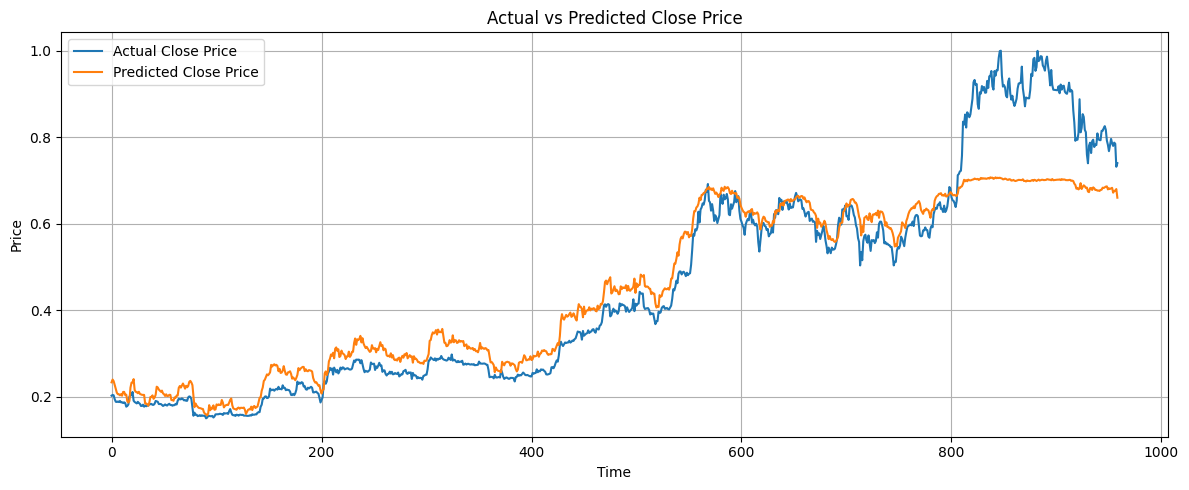

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(all_actuals[:, 0], label='Actual Close Price')
plt.plot(all_preds[:, 0], label='Predicted Close Price')
plt.title("Actual vs Predicted Close Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Volatility Plot

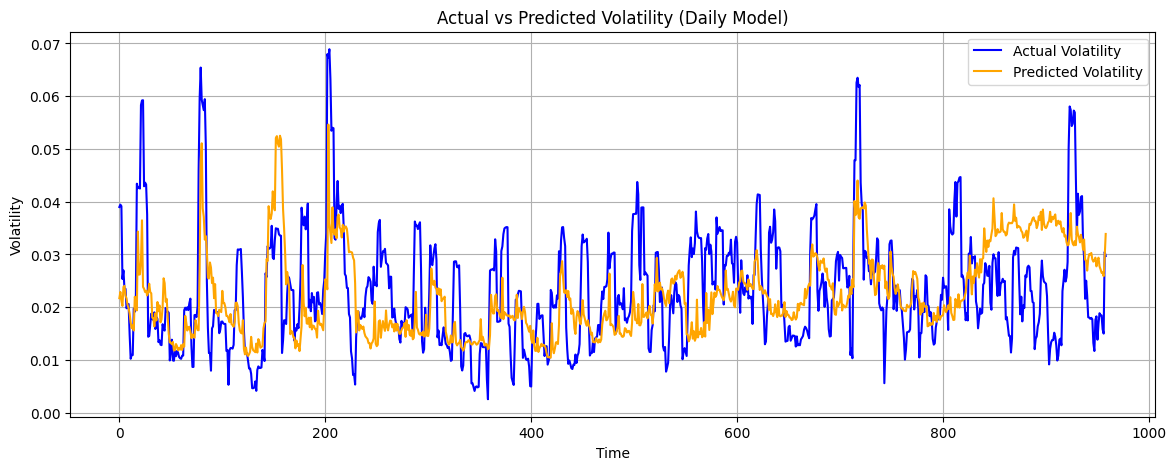

In [ ]:
# Volatility Plot using hyperparameter-tuned daily model
plt.figure(figsize=(14, 5))
plt.plot(act_vol_d, label='Actual Volatility', color='blue')
plt.plot(pred_vol_d, label='Predicted Volatility', color='orange')
plt.title("Actual vs Predicted Volatility (Daily Model)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

Save the model

In [ ]:
# Save the trained model
torch.save(model_d.state_dict(), "daily_transformer_best_model.pth")
print("Model saved as daily_transformer_best_model.pth")

Model saved as daily_transformer_best_model.pth


Save the model architecture

In [ ]:
model_config = {
    "input_size": 6,
    "d_model": 64,
    "nhead": 4,
    "num_layers": 2,
    "dropout": 0.1
}

import json
with open("daily_transformer_config.json", "w") as f:
    json.dump(model_config, f)
print("Model config saved as daily_transformer_config.json")

Model config saved as daily_transformer_config.json


Save the scaler

In [ ]:
import joblib
joblib.dump(target_scaler_d, "target_scaler_daily.pkl")
print("Target scaler saved as target_scaler_daily.pkl")

Target scaler saved as target_scaler_daily.pkl


# Hourly Prediction Model
Resample to Hourly + Feature Engineering

In [ ]:
df_hourly = df.copy()

df_hourly['Log_Returns'] = np.log(df_hourly['Close'] / df_hourly['Close'].shift(1))
df_hourly['MA_20'] = df_hourly['Close'].rolling(window=20).mean()
df_hourly['MA_50'] = df_hourly['Close'].rolling(window=50).mean()
df_hourly['EMA_20'] = df_hourly['Close'].ewm(span=20, adjust=False).mean()

rolling_std = df_hourly['Close'].rolling(window=20).std()
df_hourly['BB_upper'] = df_hourly['MA_20'] + 2 * rolling_std
df_hourly['BB_lower'] = df_hourly['MA_20'] - 2 * rolling_std

delta = df_hourly['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df_hourly['RSI'] = 100 - (100 / (1 + rs))

df_hourly['Volatility'] = df_hourly['Log_Returns'].rolling(window=60).std()
df_hourly.dropna(inplace=True)

Subset to Last Year of Hourly Data

In [ ]:
last_year = df_hourly.last("365D")

<ipython-input-152-7b542af58103>:1: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead



Define X and y

In [ ]:
from sklearn.preprocessing import MinMaxScaler

features_h = ['Close', 'Volume', 'MA_20', 'MA_50', 'EMA_20', 'BB_upper', 'BB_lower', 'RSI', 'Volatility']
X_h = last_year[features_h]
y_h = last_year[['Close', 'Volatility']]

X_scaler_h = MinMaxScaler()
y_scaler_h = MinMaxScaler()

X_scaled_h = X_scaler_h.fit_transform(X_h)
y_scaled_h = y_scaler_h.fit_transform(y_h)

Dataset Class and DataLoaders

In [ ]:
window_size_h = 48
split_h = int(len(X_scaled_h) * 0.8)

train_dataset_h = BitcoinSequenceDataset(X_scaled_h, y_scaled_h, window_size_h, start=0, end=split_h)
test_dataset_h  = BitcoinSequenceDataset(X_scaled_h, y_scaled_h, window_size_h, start=split_h)

train_loader_h = DataLoader(train_dataset_h, batch_size=64, shuffle=True)
test_loader_h  = DataLoader(test_dataset_h, batch_size=64)

Model Instantiation

In [ ]:
model_h = TimeSeriesTransformer(input_size=9).to(device)
loss_fn_h = nn.SmoothL1Loss()
optimizer_h = torch.optim.AdamW(model_h.parameters(), lr=5e-4)

Reuse the Trained Daily Model for Hourly

In [ ]:
# Define the same model but with 9 input features for hourly
hourly_model = TimeSeriesTransformer(input_size=9, d_model=64, nhead=4, num_layers=2, dropout=0.1).to(device)

# Load the trained weights from the daily model
daily_weights = torch.load("/content/daily_transformer_best_model.pth", map_location=device)

# Filter only matching layers (ignore input/output mismatches)
hourly_dict = hourly_model.state_dict()
matched_weights = {k: v for k, v in daily_weights.items() if k in hourly_dict and v.shape == hourly_dict[k].shape}
hourly_dict.update(matched_weights)
hourly_model.load_state_dict(hourly_dict)

<All keys matched successfully>

Train the Hourly Model on Last Year Data

In [ ]:
from tqdm.notebook import tqdm

epochs = 10  # or increase later
hourly_model.train()

for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader_h, desc=f"Epoch {epoch+1}/{epochs}")

    for batch_X, batch_y in loop:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_h.zero_grad()
        preds = hourly_model(batch_X)
        loss = loss_fn_h(preds, batch_y)
        loss.backward()
        optimizer_h.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader_h)
    print(f"Epoch {epoch+1} — Average Loss: {avg_loss:.4f}")


Epoch 1/10:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 1 — Average Loss: 0.0523


Epoch 2/10:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 2 — Average Loss: 0.0523


Epoch 3/10:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 3 — Average Loss: 0.0524


Epoch 4/10:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 4 — Average Loss: 0.0524


Epoch 5/10:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 5 — Average Loss: 0.0524


Epoch 6/10:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 6 — Average Loss: 0.0523


Epoch 7/10:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 7 — Average Loss: 0.0523


Epoch 8/10:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 8 — Average Loss: 0.0523


Epoch 9/10:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 9 — Average Loss: 0.0524


Epoch 10/10:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 10 — Average Loss: 0.0523


Predict and Inverse Transform

In [ ]:
hourly_model.eval()
preds_h, actuals_h = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader_h:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        pred = hourly_model(batch_X)
        preds_h.append(pred.cpu().numpy())
        actuals_h.append(batch_y.cpu().numpy())

preds_h = np.vstack(preds_h)
actuals_h = np.vstack(actuals_h)

# Inverse transform
preds_inv_h = y_scaler_h.inverse_transform(preds_h)
actuals_inv_h = y_scaler_h.inverse_transform(actuals_h)

# Separate Close and Volatility
pred_close_h, pred_vol_h = preds_inv_h[:, 0], preds_inv_h[:, 1]
act_close_h, act_vol_h = actuals_inv_h[:, 0], actuals_inv_h[:, 1]

Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_h = np.sqrt(mean_squared_error(act_close_h, pred_close_h))
mae_h = mean_absolute_error(act_close_h, pred_close_h)

# Directional Accuracy
returns_h = (act_close_h[1:] - act_close_h[:-1]) / act_close_h[:-1]
pred_returns_h = (pred_close_h[1:] - pred_close_h[:-1]) / pred_close_h[:-1]
correct_h = np.sign(returns_h) == np.sign(pred_returns_h)
dir_acc_h = correct_h.sum() / len(correct_h) * 100

# Print
print(f"RMSE (Hourly Close): {rmse_h:.4f}")
print(f"MAE  (Hourly Close): {mae_h:.4f}")
print(f"Directional Accuracy (Hourly % Returns): {dir_acc_h:.2f}%")

RMSE (Hourly Close): 40464.8936
MAE  (Hourly Close): 39786.7383
Directional Accuracy (Hourly % Returns): 47.63%


Plot Close and Volatility

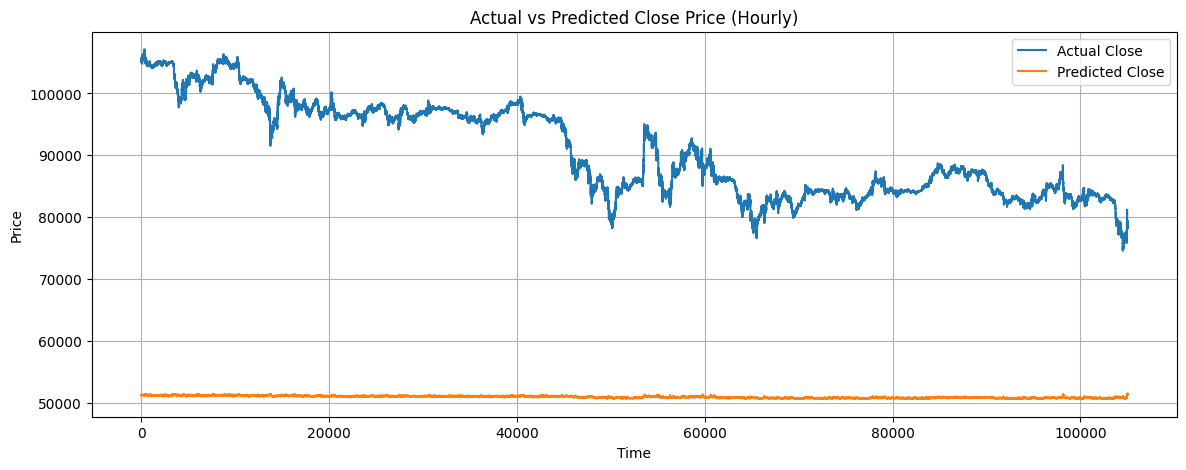

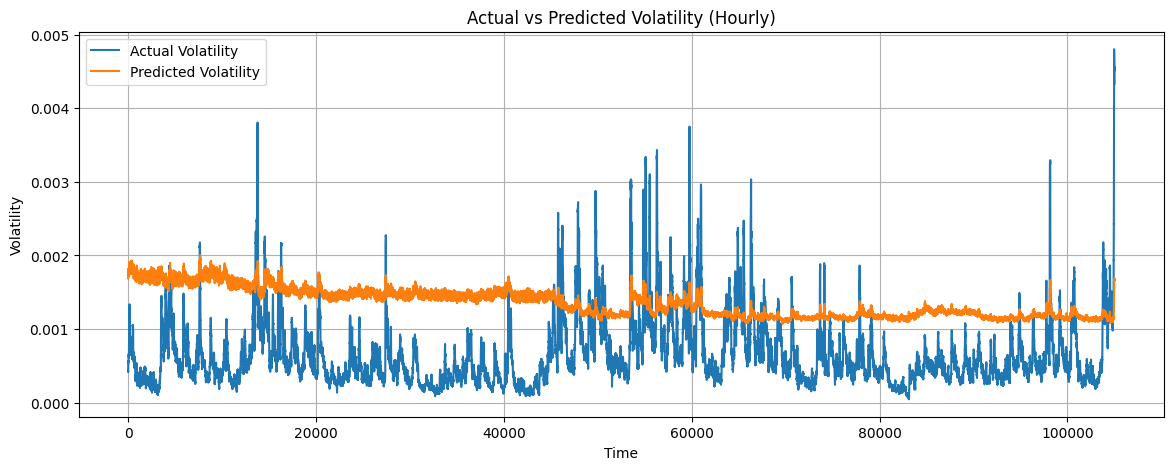

In [ ]:
import matplotlib.pyplot as plt

# Close Price
plt.figure(figsize=(14, 5))
plt.plot(act_close_h, label='Actual Close')
plt.plot(pred_close_h, label='Predicted Close')
plt.title("Actual vs Predicted Close Price (Hourly)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Volatility
plt.figure(figsize=(14, 5))
plt.plot(act_vol_h, label='Actual Volatility')
plt.plot(pred_vol_h, label='Predicted Volatility')
plt.title("Actual vs Predicted Volatility (Hourly)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

Train from scratch with a model tuned for hourly patterns (instead of reusing daily weights).

Feature Engineering (Hourly-Specific)

In [ ]:
df_hourly['Price_Change_1h'] = df_hourly['Close'].diff()
df_hourly['Rolling_STD_6h'] = df_hourly['Close'].rolling(window=6).std()
df_hourly['Rolling_Mean_12h'] = df_hourly['Close'].rolling(window=12).mean()
df_hourly.dropna(inplace=True)  # Remove resulting NaNs

features_h = [
    'Close', 'Volume', 'MA_20', 'MA_50', 'EMA_20', 'BB_upper', 'BB_lower',
    'RSI', 'Volatility', 'Price_Change_1h', 'Rolling_STD_6h', 'Rolling_Mean_12h'
]

Model Training from Scratch

In [ ]:
import torch.nn as nn
import torch

class HourlyTransformer(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=4, num_layers=2, output_size=2, dropout=0.1):
        super(HourlyTransformer, self).__init__()
        self.input_proj = nn.Linear(input_size, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        return self.output_layer(x[:, -1, :])  # Use last time step

In [ ]:
model_h = HourlyTransformer(input_size=9, d_model=64, nhead=4, num_layers=2, dropout=0.1).to(device)
loss_fn_h = nn.SmoothL1Loss()
optimizer_h = torch.optim.AdamW(model_h.parameters(), lr=5e-4)

Training Loop

In [ ]:
from tqdm.notebook import tqdm

epochs = 20
model_h.train()

for epoch in range(epochs):
    total_loss = 0
    progress = tqdm(train_loader_h, desc=f"Epoch {epoch+1}/{epochs}")

    for batch_X, batch_y in progress:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer_h.zero_grad()
        preds = model_h(batch_X)
        loss = loss_fn_h(preds, batch_y)
        loss.backward()
        optimizer_h.step()

        total_loss += loss.item()
        progress.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} — Average Loss: {total_loss/len(train_loader_h):.4f}")

Epoch 1/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 1 — Average Loss: 0.0005


Epoch 2/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 2 — Average Loss: 0.0000


Epoch 3/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 3 — Average Loss: 0.0000


Epoch 4/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 4 — Average Loss: 0.0000


Epoch 5/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 5 — Average Loss: 0.0000


Epoch 6/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 6 — Average Loss: 0.0000


Epoch 7/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 7 — Average Loss: 0.0000


Epoch 8/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 8 — Average Loss: 0.0000


Epoch 9/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 9 — Average Loss: 0.0000


Epoch 10/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 10 — Average Loss: 0.0000


Epoch 11/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 11 — Average Loss: 0.0000


Epoch 12/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 12 — Average Loss: 0.0000


Epoch 13/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 13 — Average Loss: 0.0000


Epoch 14/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 14 — Average Loss: 0.0000


Epoch 15/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 15 — Average Loss: 0.0000


Epoch 16/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 16 — Average Loss: 0.0000


Epoch 17/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 17 — Average Loss: 0.0000


Epoch 18/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 18 — Average Loss: 0.0000


Epoch 19/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 19 — Average Loss: 0.0000


Epoch 20/20:   0%|          | 0/6566 [00:00<?, ?it/s]

Epoch 20 — Average Loss: 0.0000


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# --- Metrics ---
rmse_h = np.sqrt(mean_squared_error(act_close_h, pred_close_h))  # RMSE manually
mae_h = mean_absolute_error(act_close_h, pred_close_h)

returns_h = (act_close_h[1:] - act_close_h[:-1]) / act_close_h[:-1]
pred_returns_h = (pred_close_h[1:] - pred_close_h[:-1]) / pred_close_h[:-1]
directional_accuracy_h = (np.sign(returns_h) == np.sign(pred_returns_h)).sum() / len(returns_h) * 100

print(f"RMSE (Hourly Close): {rmse_h:.4f}")
print(f"MAE  (Hourly Close): {mae_h:.4f}")
print(f"Directional Accuracy (Hourly % Returns): {directional_accuracy_h:.2f}%")

RMSE (Hourly Close): 156.1633
MAE  (Hourly Close): 104.1529
Directional Accuracy (Hourly % Returns): 48.25%


In [ ]:
print("Scaled Prediction Sample:", preds_h[:5])
print("Scaled Actual Sample    :", actuals_h[:5])

Scaled Prediction Sample: [[0.94127285 0.05971078]
 [0.94184434 0.06016953]
 [0.9420662  0.06023227]
 [0.94231415 0.0606116 ]
 [0.9424509  0.05991951]]
Scaled Actual Sample    : [[0.939999   0.06140715]
 [0.9402681  0.06147003]
 [0.94092417 0.06185872]
 [0.94099146 0.06116319]
 [0.94099146 0.0596195 ]]


Plot: Actual vs Predicted (Hourly Close Price)

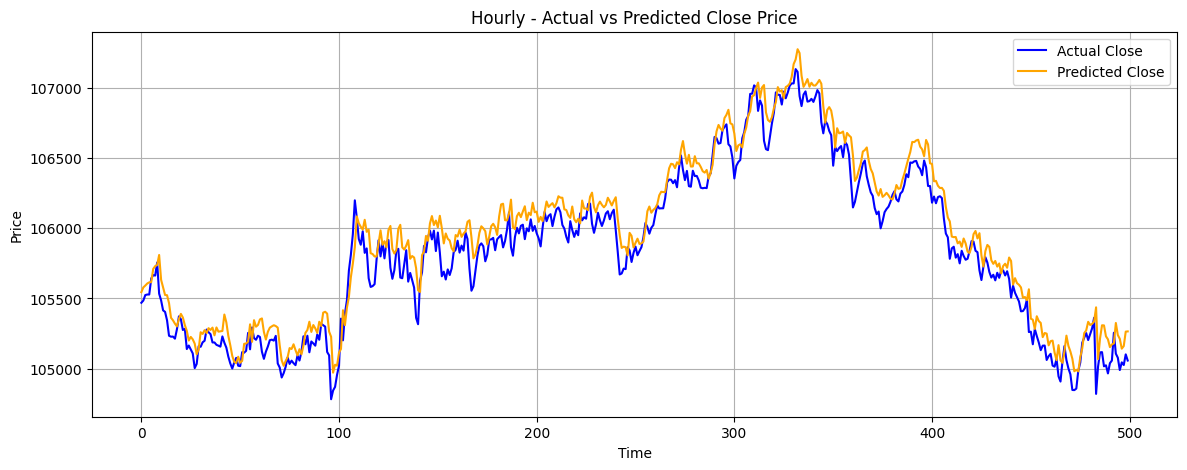

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(act_close_h[:500], label='Actual Close', color='blue')
plt.plot(pred_close_h[:500], label='Predicted Close', color='orange')
plt.title("Hourly - Actual vs Predicted Close Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

Plot: Actual vs Predicted (Hourly Volatility)

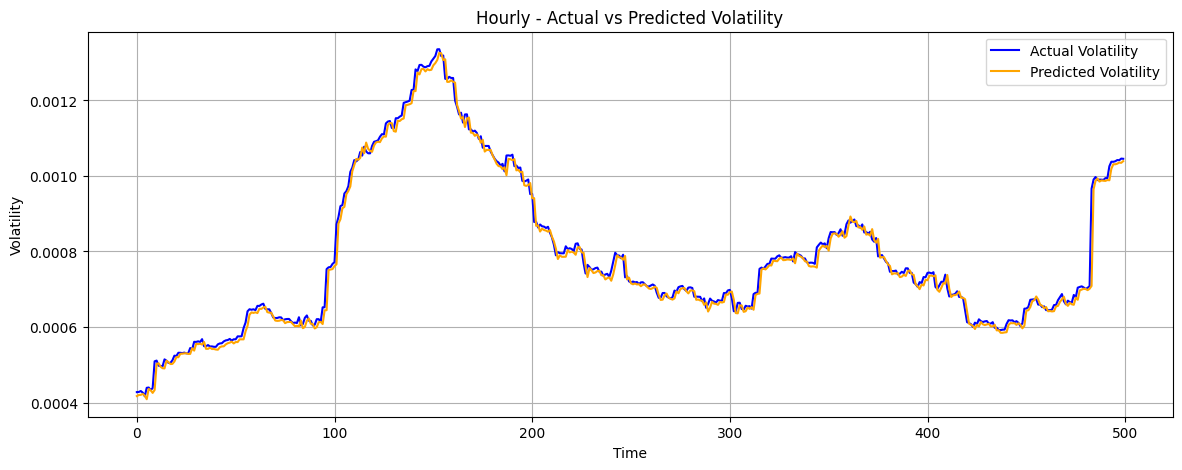

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(act_vol_h[:500], label='Actual Volatility', color='blue')
plt.plot(pred_vol_h[:500], label='Predicted Volatility', color='orange')
plt.title("Hourly - Actual vs Predicted Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

Exporting the models

In [ ]:
torch.save(model_d, "daily_transformer_full.pt")
torch.save(model_h, "hourly_transformer_full.pt")